# 情感分析之表情适配

使用RNN + WordEmbedding来建立一个表情适配器 

我们经常喜欢在文字后面加上表情来使得我们的文字更加有表达性和感染力，但是每次输入完文字都需要我们花上一定的时间去挑选表情。而本项目的目的在于在用户输入完文字之后能够自动配上相应场景的表情，使得语句更具有表达性同时又节省了用户的时间与精力。比如在我们输完语句 "Congratulations on the promotion! Lets get coffee and talk. Love you!"之后，表情适配器能够自动在每句话后添加上表情，如： "Congratulations on the promotion! 👍 Lets get coffee and talk. ☕️ Love you! ❤️"

我们将完成一个模型，在输入一个句子（如"I want to play basketball!"）之后，模型将会找到最匹配当前语句的表情（⚾️）加在语句的结尾处。在许多现有的模型中，模型将只会记得❤️是"heart"的标志，但当换了一个词例如"love"的时候，模型将不会识别出。而在本项目中，我们将使用词向量来表征每一个单词，使得算法能够泛化到训练集中没有出现的词汇中，如训练集中的❤️是"heart"的标志，当我们输入训练集中没有的词汇"love"时，❤️也会被自动添加上。因此，词向量的引入还允许我们使用一个较小的训练集来训练我们的模型。

In [3]:
import numpy as np
from expression_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

## 1 - 数据预处理

### 1.1 - 数据集 EMOJISET

我们有一个较小的数据集(X, Y)

- X 含有127个句子（都是字符串）
- Y 含有一个整数标签（0-4）分别对应每个句子所适用的表情

<img src="images/data_set.png" style="width:700px;height:300px;">
<caption><center> **Figure 1**: EMOJISET - 一个有着5个类的分类问题，这里给出了一些句子的例子</center></caption>

划分数据集为训练集（127个例子）和测试集（56个例子） 

In [4]:
X_train, Y_train = read_csv('data/train.csv')
X_test, Y_test = read_csv('data/test.csv')

In [5]:
maxLen = len(max(X_train, key=len).split())

打印X_train中的某个句子和对应的标签，index可以自行改变

In [6]:
index = 5
print(X_train[index], label_to_emoji(Y_train[index]))

I love you mum ❤️


为了使标签格式化，使用"one-hot representation"转换$Y$从维度$(m, 1)$到 $(m, 5)$


In [7]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

查看转换后Y标签的效果，index可以自行改变

In [8]:
index = 5
print(Y_train[index], "转换为one hot向量", Y_oh_train[index])

0 转换为one hot向量 [1. 0. 0. 0. 0.]




将输入句子转换成词向量表征形式，我们使用50维的GloVe embeddings.

In [9]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/GloveWordEmbedding.txt')

生成3个python字典
- `word_to_index`: 将每个单词映射为他们在词汇表所对应的索引（词汇表中共400001个单词，对应着索引0-400000）
- `index_to_word`: 将每个索引映射为他们在词汇表所对应的单词
- `word_to_vec_map`: 将每个单词映射为GloVe向量表征形式

测试转换效果，index可以自行改变

In [10]:
word = "cucumber"
index = 289846
print(word, "在词汇表中的索引为", word_to_index[word])
print("索引", str(index) + "在词汇表中对应的单词是", index_to_word[index])

cucumber 在词汇表中的索引为 113317
索引 289846在词汇表中对应的单词是 potatos


## 2 - 搭建神经网络

## 2.1 - 模型1

### 2.1.1 - 模型结构
<center>
<img src="images/model1.png" style="width:900px;height:300px;">
<caption><center> **Figure 2**: Average model.</center></caption>
</center>

In [11]:
def sentence_to_avg(sentence, word_to_vec_map):
   
    words = sentence.lower().split()

    avg = np.zeros((50,))
    
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg / len(words)
    
    return avg

测试某个句子的均值词向量

In [14]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


### 2.1.2 - 建立模型

In [15]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    
    np.random.seed(1)

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = W @ avg + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(Y_oh[i] * np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [16]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 5)
<class 'numpy.ndarray'>


In [17]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.9520498812810072
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014807
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]

### 2.1.3 - 测试性能

In [18]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


In [19]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


该算法有一个很大的缺陷，它并没有使得“not feeling happy”正确。 该算法忽略了单词排序，因此不善于理解“不开心”这样的短语。

打印混淆矩阵还有助于了解哪些类对于模型理解更加困难。 混淆矩阵显示了标签是一个类（“实际”类）的示例经常被具有不同类（“预测”类）的算法错误标记的频率。

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


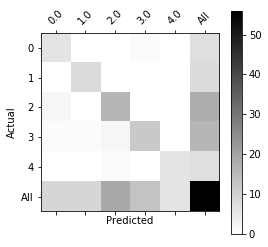

In [20]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

## 2.2 - 模型2 
### 使用Keras框架建立LSTMs单元：
使用预训练的次嵌入表征每个单词，然后喂给LSTM单元

In [21]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

G:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 2.2.1 - 模型结构

<img src="images/model2.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: 2层LSTM序列分类器. </center></caption>



### 2.2.2 填充训练集语句

对于一个选定的深度神经网络，我们需要每个输入的语句有着相同的长度，即有相同数量的单词。但是现在训练集中的句子长度不一，所以我们使用padding来填充每个句子。使用训练集所有句子中最长的句子的长度作为输入RNN的语句长度，长度低于最长长度的句子中剩余词向量就用零向量进行填充。


### 2.2.3 - Embedding层

Embedding层使用(batch size, max input length)作为输入。

<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center> **Figure 4**: Embedding层. 这个例子展示了两个语句通过embedding层的前向传播过程。两个语句都用0填充到了长度5.最终的维度是`(2,max_len,50)`，因为我们使用的词嵌入是50维的。 </center></caption>


第一步先将所有训练的句子转换为对应的索引列表，然后再用0填充长度不满max_len的句子。


In [22]:
def sentences_to_indices(X, word_to_index, max_len):
    
   
    m = X.shape[0]                                
    

    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                             
        
        sentence_words = X[i].lower().split()
        
        j = 0
        
        for w in sentence_words:
  
            X_indices[i, j] = word_to_index[w]
        
            j = j + 1
            
    return X_indices

查看 `sentences_to_indices()` 效果

In [23]:
X1 = np.array(["everyday is nice", "let us play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['everyday is nice' 'let us play baseball' 'food is ready for you']
X1_indices = [[141944. 192973. 260760.      0.      0.]
 [220870. 374021. 286375.  69714.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


在Kreas中建立`Embedding()` 层

In [24]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
 
    
    vocab_len = len(word_to_index) + 1                 
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    
  
    emb_matrix = np.zeros((vocab_len, emb_dim))
    

    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)


    embedding_layer.build((None,))
    
    
    embedding_layer.set_weights([emb_matrix]) # 对应后面的[][][]三个维度
    
    return embedding_layer

## 2.2.4 建立模型

建立模型，将embedding层的输出喂给LSTM网络

<img src="images/model.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 5**: 一个两层的LSTM序列分类器 </center></caption>

In [25]:
def LSTMModel(input_shape, word_to_vec_map, word_to_index):

    sentence_indices = Input(input_shape, dtype='int32')

    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices)  
    
    X = LSTM(128, return_sequences=True)(embeddings)
   
    X = Dropout(0.5)(X)

    X = LSTM(128, return_sequences=False)(X)
   
    X = Dropout(0.5)(X)
    
    X = Dense(5)(X)
    
    X = Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

Model Summary

In [26]:
model = LSTMModel((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

编译模型，使用交叉熵损失函数，并将准确率作为评估指标 

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

训练模型

In [28]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

迭代50次，每代每个批次的数据大小为32

In [30]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
132/132 [==============================] - 0s 1ms/step - loss: 0.1922 - acc: 0.9545
Epoch 2/50
132/132 [==============================] - 0s 1ms/step - loss: 0.0972 - acc: 0.9697
Epoch 3/50
132/132 [==============================] - 0s 1ms/step - loss: 0.1390 - acc: 0.9394
Epoch 4/50
132/132 [==============================] - 0s 1ms/step - loss: 0.1015 - acc: 0.9697
Epoch 5/50
132/132 [==============================] - 0s 1ms/step - loss: 0.0793 - acc: 0.9773
Epoch 6/50
132/132 [==============================] - 0s 1ms/step - loss: 0.0530 - acc: 0.9848
Epoch 7/50
132/132 [==============================] - 0s 1ms/step - loss: 0.0362 - acc: 0.9924
Epoch 8/50
132/132 [==============================] - 0s 1ms/step - loss: 0.0303 - acc: 0.9924
Epoch 9/50
132/132 [==============================] - ETA: 0s - loss: 0.0242 - acc: 1.000 - 0s 1ms/step - loss: 0.0279 - acc: 1.0000
Epoch 10/50
132/132 [==============================] - 0s 1ms/step - loss: 0.0142 - acc: 1.0000
Epoch 11/50

查看测试集准确率

In [31]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

56/56 [==============================] - 0s 6ms/step

Test accuracy =  0.8392857228006635


查看错误分类情况

In [32]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	😄
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:😞 prediction: go away	⚾


尝试自己的测试语句

In [33]:
inputSentence = "I am hungry"
x_test = np.array([inputSentence])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I am hungry 🍴


## 3 - 保存模型

In [34]:
model.save('my_model.h5')

## 4 - 加载模型

In [37]:
from keras.models import load_model

In [38]:
model = load_model('model/my_model.h5')

尝试自己的测试语句

In [41]:
inputSentence = "I am very glad to see you"
x_test = np.array([inputSentence])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I am very glad to see you 😄
